<a href="https://colab.research.google.com/github/around-star/Classification-on-CIFAR-Dataset/blob/master/cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
print(tf.__version__)

2.2.0-rc1


In [ ]:
import os
from google.colab import drive
drive.mount('/gdrive')
os.chdir('/gdrive/My Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
cifar_dir='Colab Notebooks/cifar-10-batches-py/'

In [ ]:
def unpickle(file):
    import pickle
    with open(file,'rb') as fo:
        cifar_dict=pickle.load(fo,encoding='bytes')
    return cifar_dict

In [ ]:
dirs=['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [ ]:
all_data=[0,1,2,3,4,5,6]

In [ ]:
for i,direc in zip(all_data,dirs):
    all_data[i]=unpickle(os.path.join(cifar_dir,direc))

In [ ]:
batch_meta=all_data[0]
batch_1=all_data[1]
batch_2=all_data[2]
batch_3=all_data[3]
batch_4=all_data[4]
batch_5=all_data[5]
test_batch=all_data[6]

In [ ]:
batch_1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [ ]:
x=batch_1[b"data"]

In [ ]:
len(x[0])

3072

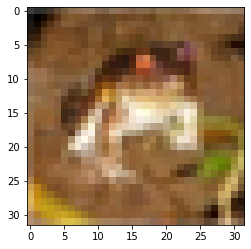

In [ ]:
plt.imshow(x[0].reshape(3,32,32).transpose(1,2,0))

In [ ]:
def one_hot_encode(vec,val=10):
    n=len(vec)
    a=np.zeros((n,val))
    a[range(n),vec]=1
    return a

In [ ]:
class CifarHelper():
    def __init__(self):
        self.i=0
        
        self.all_train_batches=[batch_1,batch_2,batch_3,batch_4,batch_5]
        self.test_batch=[test_batch]
        
        self.training_images=None
        self.training_labels=None
        
        self.test_images=None
        self.test_labels=None
        
    def set_up_images(self):
        print("Setting up Training Images and Labels")
        
        self.training_images=np.vstack([d[b'data'] for d in self.all_train_batches])
        train_len=len(self.training_images)
        
        self.training_images=self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels=one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]),10)
        
        print("Setting up Testing Images and Labels")
        
        self.test_images=np.vstack([d[b"data"] for d in self.test_batch])
        test_len=len(self.test_images)
        
        self.test_images=self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels=one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]),10)
        
    def next_batch(self,batch_size):
        x=self.training_images[self.i:self.i+batch_size]
        y=self.training_labels[self.i:self.i+batch_size]
        self.i=(self.i+batch_size)%len(self.training_images)
        
        return x,y

In [ ]:
ch=CifarHelper()
ch.set_up_images()

Setting up Training Images and Labels
Setting up Testing Images and Labels


In [ ]:
def initial_weights(shape):
    random_weights=tf.random.truncated_normal(shape,stddev=0.1)
    return tf.Variable(random_weights)

In [ ]:
def initial_bias(shape):
    random_bias=tf.constant(0.1,shape=shape)
    return tf.Variable(random_bias)

In [ ]:
def conv2D(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')

def convolutional_layer(input_x,shape):
    w=initial_weights(shape)
    b=initial_bias([shape[3]])
    return tf.nn.relu(conv2D(input_x,w)+b)

def max_pool_2by2(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

def normal_full_layer(input_layer,size):
    input_size=int(input_layer.get_shape()[1])
    w=initial_weights([input_size,size])
    b=initial_bias([size])
    return tf.matmul(input_layer,w)+b

In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
x=tf.compat.v1.placeholder(tf.float32,shape=[None,32,32,3])
y_true=tf.compat.v1.placeholder(tf.float32,shape=[None,10])
hold_prob=tf.compat.v1.placeholder(tf.float32)

In [ ]:
convo_1=convolutional_layer(x,shape=[4,4,3,32])
convo_1_pooling=max_pool_2by2(convo_1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
convo_2=convolutional_layer(convo_1_pooling,shape=[4,4,32,64])
convo_2_pooling=max_pool_2by2(convo_2)

In [ ]:
convo_2_flat=tf.reshape(convo_2_pooling,[-1,8*8*64])

In [ ]:
full_layer=normal_full_layer(convo_2_flat,1024)

In [ ]:
full_layer_relu=tf.nn.relu(full_layer)

In [ ]:
full_layer_dropout=tf.compat.v1.nn.dropout(full_layer_relu,hold_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
y_pred=normal_full_layer(full_layer_dropout,10)

In [ ]:
cross_entropy=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

In [ ]:
optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=0.0001)
train=optimizer.minimize(cross_entropy)

In [ ]:
matches=tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
acc=tf.reduce_mean(tf.cast(matches,tf.float32))

In [ ]:
init=tf.compat.v1.global_variables_initializer()

In [ ]:
with tf.compat.v1.Session() as sess:
    sess.run(init)
    
    for i in range(5000):
        batch=ch.next_batch(100)
        _, loss = sess.run([train, cross_entropy],feed_dict={x:batch[0],y_true:batch[1],hold_prob:0.9})
        #print(loss)
        if i%100 == 0:
          print(sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0}))

0.1049
0.3114
0.3733
0.4155
0.4448
0.4571
0.4773
0.4929
0.5012
0.5071
0.511
0.5254
0.5355
0.535
0.5417
0.541
0.5553
0.5588
0.558
0.5699
0.5684
0.5802
0.5821
0.5766
0.5911
0.5816
0.6009
0.5998
0.5913
0.6046
0.5991
0.6129
0.6163
0.604
0.6164
0.611
0.6277
0.6282
0.6158
0.6266
0.6221
0.6357
0.6343
0.6215
0.6381
0.6317
0.6481
0.6422
0.6349
0.6431
